In [ ]:
# Check current versions
!python -c "import numpy; print('Current numpy version:', numpy.__version__)"
!python -c "import torch; print('Current torch version:', torch.__version__)"

# Install desired versions with CUDA 12.4
!pip install numpy==1.26.4
!pip install torch==2.3.0+cu124 -f https://download.pytorch.org/whl/torch_stable.html
!pip install torch-scatter -f https://data.pyg.org/whl/torch-2.3.0+cu124.html
!pip install torcheeg
!pip install pytorch-lightning

# This will show the versions in new Python processes
!python -c "import numpy; print('Installed numpy version:', numpy.__version__)"
!python -c "import torch; print('Installed torch version:', torch.__version__)"

print("\n*** IMPORTANT: Please restart the runtime now for changes to take effect in this notebook  (search for 'restart session' in top left 'commands' ***")

In [ ]:
import torch

print(f"PyTorch version: {torch.__version__}")
print(f"CUDA version: {torch.version.cuda}")

if torch.cuda.is_available():
    accelerator = "gpu"
    pin_memory = True
    print("GPU is available. Training will use GPU acceleration.")
else:
    accelerator = "cpu"
    pin_memory = False
    print("WARNING: GPU not available, using CPU instead")

/bin/bash: line 1: nvidia-smi: command not found
PyTorch version: 2.6.0+cu124
CUDA version: 12.4


In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
experiment_name = input("name your experiment (or use old one) > ")  # like sst_01

name your experiment (or use old one) > stat_02


In [ ]:
import os

IO_PATH = f'/content/drive/MyDrive/datasets/STEW/io/{experiment_name}/' # not-existant or populated - ! NOT EMPTY !
MODEL_SAVE_PATH = f'/content/drive/MyDrive/datasets/STEW/model/{experiment_name}/' # is going to be created if it doesn't exist yet
DATA_FOLDER_PATH = '/content/drive/MyDrive/datasets/STEW/dataset' # has to exist

if not os.path.exists(MODEL_SAVE_PATH):
    print(f"model folder not existing, creating at {MODEL_SAVE_PATH}")
    os.mkdir(MODEL_SAVE_PATH)
else:
    print(f"ATTENTION: model folder already exists, only proceed if you are ready to overwrite")

if not os.path.exists(DATA_FOLDER_PATH):
    raise Exception("make sure dataset exists")


SEED:int = 42
BATCH_SIZE:int = 64
N_WORKERS:int = 2

model folder not existing, creating at /content/drive/MyDrive/datasets/STEW/model/stat_02/


# loading data

In [ ]:
"""
should take about a minute
"""

import os
import numpy as np
import mne
from typing import List, Dict


def load_stew_dataset(stew_path: str, subjects: List[int] = None) -> tuple:
    """
    Load the STEW (Sustained-Task EEG Workload) dataset from TXT files.

    Parameters:
        stew_path (str): Path to the STEW dataset directory
        subjects (List[int], optional): List of subject IDs to load. If None, loads all available subjects.

    Returns:
        tuple: (raw_list, info_list) for use with MNERawDataset
    """
    # EEG channel names in the correct order
    channel_names = ['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4']

    # If no subjects specified, find all available subjects
    if subjects is None:
        subjects = set()
        for filename in os.listdir(stew_path):
            if filename.startswith('sub') and filename.endswith('.txt'):
                try:
                    subject_id = int(filename[3:5])
                    subjects.add(subject_id)
                except ValueError:
                    continue
        subjects = sorted(list(subjects))

    raw_list = []
    info_list = []

    # Task mapping
    task_mapping = {
        'lo': 'low',
        'hi': 'high'
    }

    for subject in subjects:
        # Format subject ID with leading zero if needed
        subject_str = f"{subject:02d}"

        # Check for both task conditions
        for task_code in ['lo', 'hi']:
            filename = f"sub{subject_str}_{task_code}.txt"
            file_path = os.path.join(stew_path, filename)

            if os.path.exists(file_path):
                try:
                    # Load EEG data from txt file
                    eeg_data = np.loadtxt(file_path)

                    # Assume sampling rate of 128 Hz (adjust if different)
                    sfreq = 128

                    # Create MNE info structure
                    info = mne.create_info(
                        ch_names=channel_names,
                        sfreq=sfreq,
                        ch_types=['eeg'] * len(channel_names)
                    )

                    # Create Raw object
                    raw = mne.io.RawArray(eeg_data.T, info)

                    # Create metadata dictionary
                    metadata = {
                        'subject_id': subject,
                        'task': task_mapping[task_code],
                        'trial_id': task_code,
                        'workload_level': 0 if task_code == 'lo' else 1
                    }

                    raw_list.append(raw)
                    info_list.append(metadata)

                    # print(f"Loaded {filename}: {eeg_data.shape} samples")

                except Exception as e:
                    print(f"Error loading {file_path}: {e}")

    return raw_list, info_list


raw_list, info_list = load_stew_dataset(DATA_FOLDER_PATH)
print(f"\n\nLoaded {len(raw_list)} recordings from {len(set([info['subject_id'] for info in info_list]))} subjects")

  0%|          | 0/48 [00:00<?, ?it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  2%|▏         | 1/48 [00:04<03:35,  4.59s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  4%|▍         | 2/48 [00:05<01:58,  2.58s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  6%|▋         | 3/48 [00:06<01:21,  1.81s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


  8%|▊         | 4/48 [00:07<01:06,  1.52s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 10%|█         | 5/48 [00:08<00:57,  1.33s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 12%|█▎        | 6/48 [00:09<00:54,  1.30s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 15%|█▍        | 7/48 [00:10<00:47,  1.16s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 17%|█▋        | 8/48 [00:11<00:44,  1.10s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 19%|█▉        | 9/48 [00:13<00:44,  1.13s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 21%|██        | 10/48 [00:14<00:42,  1.12s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 23%|██▎       | 11/48 [00:15<00:40,  1.10s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 25%|██▌       | 12/48 [00:16<00:44,  1.23s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 27%|██▋       | 13/48 [00:17<00:42,  1.20s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 29%|██▉       | 14/48 [00:19<00:42,  1.24s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 31%|███▏      | 15/48 [00:20<00:39,  1.19s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 33%|███▎      | 16/48 [00:21<00:38,  1.19s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 35%|███▌      | 17/48 [00:22<00:36,  1.17s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 38%|███▊      | 18/48 [00:23<00:31,  1.04s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 40%|███▉      | 19/48 [00:23<00:26,  1.08it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 42%|████▏     | 20/48 [00:24<00:25,  1.09it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 44%|████▍     | 21/48 [00:25<00:24,  1.10it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 46%|████▌     | 22/48 [00:26<00:23,  1.11it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 48%|████▊     | 23/48 [00:27<00:21,  1.18it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 50%|█████     | 24/48 [00:28<00:20,  1.17it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 52%|█████▏    | 25/48 [00:28<00:18,  1.22it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 54%|█████▍    | 26/48 [00:29<00:18,  1.18it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 56%|█████▋    | 27/48 [00:30<00:17,  1.20it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 58%|█████▊    | 28/48 [00:31<00:16,  1.20it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 60%|██████    | 29/48 [00:32<00:15,  1.19it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 62%|██████▎   | 30/48 [00:33<00:14,  1.20it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 65%|██████▍   | 31/48 [00:33<00:13,  1.24it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 67%|██████▋   | 32/48 [00:34<00:12,  1.30it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 69%|██████▉   | 33/48 [00:35<00:11,  1.31it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 71%|███████   | 34/48 [00:36<00:11,  1.27it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 73%|███████▎  | 35/48 [00:36<00:09,  1.30it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 75%|███████▌  | 36/48 [00:37<00:09,  1.32it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 77%|███████▋  | 37/48 [00:38<00:08,  1.31it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 79%|███████▉  | 38/48 [00:39<00:08,  1.23it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 81%|████████▏ | 39/48 [00:40<00:07,  1.18it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 83%|████████▎ | 40/48 [00:41<00:07,  1.11it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 85%|████████▌ | 41/48 [00:42<00:06,  1.03it/s]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 88%|████████▊ | 42/48 [00:43<00:06,  1.06s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 90%|████████▉ | 43/48 [00:44<00:05,  1.13s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 92%|█████████▏| 44/48 [00:46<00:04,  1.12s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 94%|█████████▍| 45/48 [00:47<00:03,  1.11s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 96%|█████████▌| 46/48 [00:48<00:02,  1.06s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


 98%|█████████▊| 47/48 [00:49<00:01,  1.02s/it]

Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.
Creating RawArray with float64 data, n_channels=14, n_times=19200
    Range : 0 ... 19199 =      0.000 ...   149.992 secs
Ready.


100%|██████████| 48/48 [00:49<00:00,  1.04s/it]



Loaded 96 recordings from 48 subjects


In [ ]:
for raw in raw_list:
    raw.filter(0.5, 45)
    raw.notch_filter(50)

import os
os.clear()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.5 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.50
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 0.25 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 845 samples (6.602 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband ed

<RawArray | 14 x 19200 (150.0 s), ~2.1 MiB, data loaded>
['AF3', 'F7', 'F3', 'FC5', 'T7', 'P7', 'O1', 'O2', 'P8', 'T8', 'FC6', 'F4', 'F8', 'AF4'] None
Using matplotlib as 2D backend.


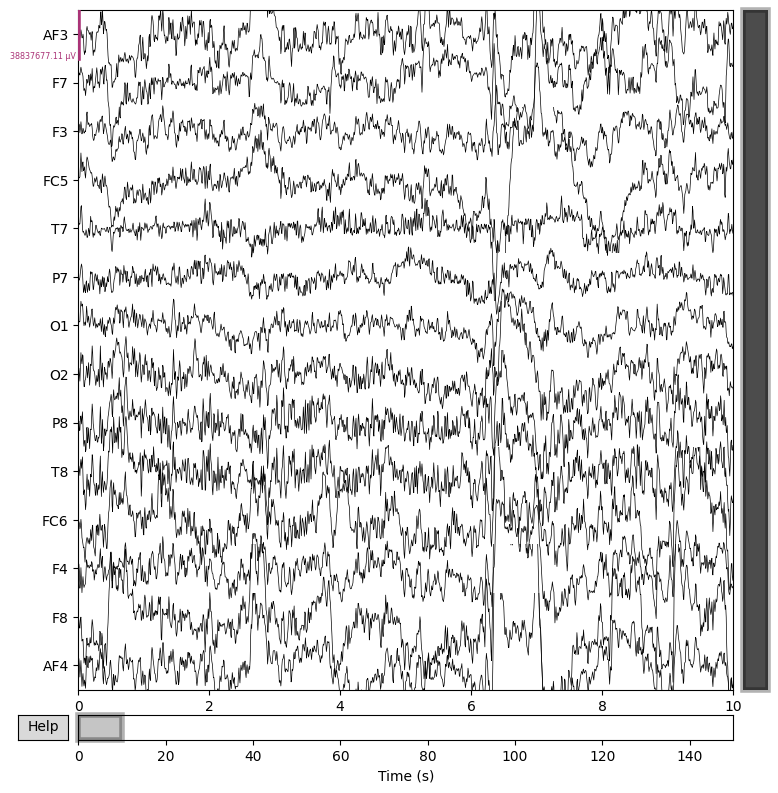

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 16.000 (s)
Plotting power spectral density (dB=True).


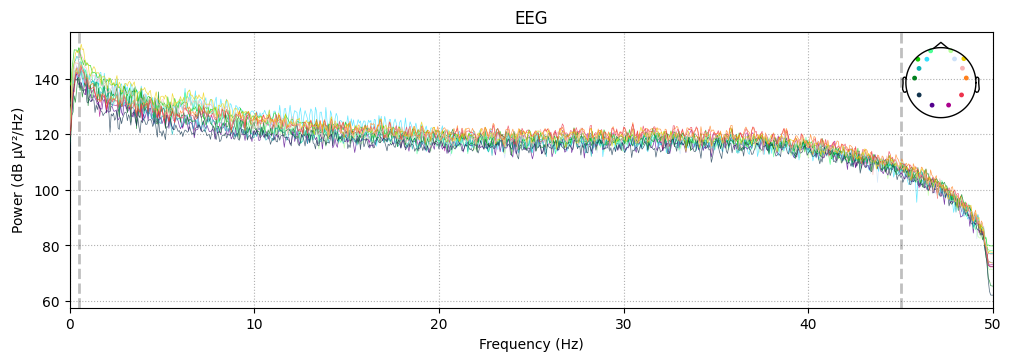

In [ ]:
import random
import matplotlib.pyplot as plt

raw = random.choice(raw_list)

print(raw)
print(raw.info["ch_names"], raw.get_montage())

montage = mne.channels.make_standard_montage("standard_1020")
raw.set_montage(montage)

# raw.filter(1, 40)  # Bandpass filter from 1-40 Hz

# plot raw graph
fig = raw.plot(duration=10, n_channels=20, scalings='auto', title='Raw Data')

# Plot power spectral density
fig_psd = raw.plot_psd(fmax=50)

# plot the Power-Spectral-Density for each frequency - has a safety mechanism to not display frequencies you couldn't have captured (Nyquist-Shannon sampling theory)
# fig_psd_bands = raw.plot_psd_topo(fmax=60)

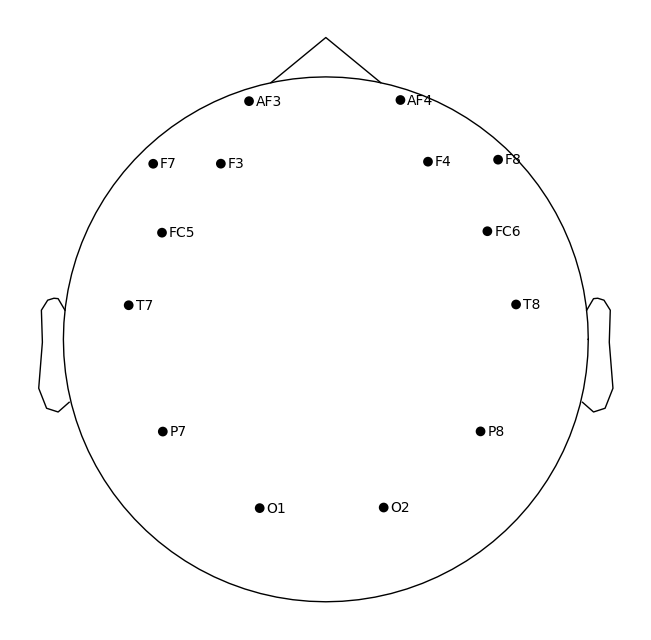

{'AF3': (np.float64(-0.035186007467538326), np.float64(0.10912956509481905)), 'F7': (np.float64(-0.07187662505917264), np.float64(0.07310352742670875)), 'F3': (np.float64(-0.05180903841183724), np.float64(0.08668789888287941)), 'FC5': (np.float64(-0.07890597635539306), np.float64(0.05136738419239063)), 'T7': (np.float64(-0.08598207795805729), np.float64(0.014871638175652204)), 'P7': (np.float64(-0.07445796452347851), np.float64(-0.042123164958505765)), 'O1': (np.float64(-0.03157355787465608), np.float64(-0.08056835212663661)), 'O2': (np.float64(0.027683100559624117), np.float64(-0.08048883980936473)), 'P8': (np.float64(0.07103247088902218), np.float64(-0.04225997601209522)), 'T8': (np.float64(0.08326136985759491), np.float64(0.015258189278681372)), 'FC6': (np.float64(0.0778466192866476), np.float64(0.052098811200362666)), 'F4': (np.float64(0.050274277731628736), np.float64(0.08743838910239796)), 'F8': (np.float64(0.07143526925150917), np.float64(0.07450512647808137)), 'AF4': (np.float6

In [ ]:
# Plot topographic map of channel positions
fig_topo = raw.plot_sensors(show_names=True)

def get_channel_locations_from_mne(raw):
    """Extract channel locations from MNE object for TorchEEG."""
    # First ensure a montage is set
    if raw.get_montage() is None:
        montage = mne.channels.make_standard_montage('standard_1020')
        raw.set_montage(montage)

    # Get positions (returns 3D coordinates)
    pos_3d = raw.get_montage().get_positions()['ch_pos']

    # Extract only the channels present in the raw object
    ch_names = raw.ch_names

    # Convert to 2D coordinates for TorchEEG (x,y)
    # We'll use the top-down view (x,y coordinates)
    location_dict = {}
    for ch in ch_names:
        if ch in pos_3d:
            # Get x,y coordinates (ignore z)
            x, y, _ = pos_3d[ch]
            location_dict[ch] = (x, y)

    return location_dict


# --- !! has to match the channel names in the info of the MNE raw objects
# STEW_CHANNEL_LOCATION_DICT = {
#     'AF3': (-0.3, 0.8),
#     'F7': (-0.8, 0.4),
#     'F3': (-0.4, 0.7),
#     'FC5': (-0.8, 0.0),
#     'T7': (-1.0, -0.2),
#     'P7': (-0.8, -0.6),
#     'O1': (-0.4, -1.0),
#     'O2': (0.4, -1.0),
#     'P8': (0.8, -0.6),
#     'T8': (1.0, -0.2),
#     'FC6': (0.8, 0.0),
#     'F4': (0.4, 0.7),
#     'F8': (0.8, 0.4),
#     'AF4': (0.3, 0.8)
# }

STEW_CHANNEL_LOCATION_DICT = get_channel_locations_from_mne(raw)

print(STEW_CHANNEL_LOCATION_DICT)

#statistical

###https://www.nature.com/articles/s41598-024-84429-6

In [ ]:
"""
VIBE CODED https://www.nature.com/articles/s41598-024-84429-6
"""

import numpy as np
from tqdm import tqdm
from scipy import signal
from sklearn.ensemble import VotingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# --- entropy functions
def sample_entropy(x, m=2, r=0.2):
    """Calculate sample entropy of a time series"""
    n = len(x)
    if n == 0:
        return 0

    # Normalize the standard deviation to 1
    if np.std(x) > 0:
        x = (x - np.mean(x)) / np.std(x)
    else:
        return 0

    # Set r relative to the standard deviation
    r = r * np.std(x)

    # Create templates of length m and m+1
    templates_m = np.array([x[i:i+m] for i in range(n-m+1)])
    templates_m1 = np.array([x[i:i+m+1] for i in range(n-m)])

    # Count similar templates
    B = 0
    A = 0

    for i in range(n-m):
        # Count similar templates of length m
        template = templates_m[i]
        dists = np.max(np.abs(templates_m - template), axis=1)
        B += np.sum(dists < r) - 1  # Exclude self-match

        # Count similar templates of length m+1
        template = templates_m1[i]
        dists = np.max(np.abs(templates_m1 - template), axis=1)
        A += np.sum(dists < r) - 1  # Exclude self-match

    # Calculate sample entropy
    if B == 0 or A == 0:
        return 0

    return -np.log(A / B)

def fuzzy_entropy(x, m=2, r=0.2, n=2):
    """Calculate fuzzy entropy of a time series"""
    N = len(x)
    if N == 0:
        return 0

    # Normalize the standard deviation to 1
    if np.std(x) > 0:
        x = (x - np.mean(x)) / np.std(x)
    else:
        return 0

    # Set r relative to the standard deviation
    r = r * np.std(x)

    # Create templates of length m and m+1
    templates_m = np.array([x[i:i+m] for i in range(N-m+1)])
    templates_m1 = np.array([x[i:i+m+1] for i in range(N-m)])

    # Calculate similarity using fuzzy membership function
    def similarity(a, b, r):
        d = np.max(np.abs(a - b))
        return np.exp(-np.power(d, n) / r)

    # Calculate phi_m and phi_m+1
    phi_m = 0
    for i in range(N-m):
        for j in range(N-m):
            if i != j:
                phi_m += similarity(templates_m[i], templates_m[j], r)

    phi_m1 = 0
    for i in range(N-m-1):
        for j in range(N-m-1):
            if i != j:
                phi_m1 += similarity(templates_m1[i], templates_m1[j], r)

    # Avoid division by zero
    if phi_m == 0:
        return 0

    # Calculate fuzzy entropy
    return np.log(phi_m / phi_m1)

def renyi_entropy(x, alpha=2):
    """Calculate Renyi entropy of a time series"""
    # Create histogram
    hist, _ = np.histogram(x, bins=100, density=True)
    hist = hist[hist > 0]  # Remove zeros

    # Calculate Renyi entropy
    if len(hist) == 0:
        return 0

    return 1/(1-alpha) * np.log(np.sum(np.power(hist, alpha)))

def differential_entropy(x):
    """Calculate differential entropy of a time series (assuming Gaussian)"""
    if len(x) == 0 or np.std(x) <= 0:
        return 0

    # For Gaussian distribution
    return 0.5 * np.log(2 * np.pi * np.e * np.var(x))

# --- other functions
def find_extrema(signal_data):
    """Find local maxima and minima in the signal"""
    maxima_idx = signal.argrelmax(signal_data)[0]
    minima_idx = signal.argrelmin(signal_data)[0]
    extrema_idx = np.sort(np.concatenate((maxima_idx, minima_idx)))
    return extrema_idx

def compute_local_mean(signal_data, extrema_idx):
    """Compute local mean between consecutive extrema"""
    local_mean = np.zeros_like(signal_data)
    for i in range(len(extrema_idx)-1):
        start, end = extrema_idx[i], extrema_idx[i+1]
        local_mean[start:end+1] = (signal_data[start] + signal_data[end]) / 2
    return local_mean

def compute_envelope(signal_data, extrema_idx):
    """Compute envelope function"""
    envelope = np.zeros_like(signal_data)
    for i in range(len(extrema_idx)-1):
        start, end = extrema_idx[i], extrema_idx[i+1]
        envelope[start:end+1] = abs(signal_data[start] - signal_data[end]) / 2
    return envelope

# --- main RobustLocalMeanDistribution funtion (fourrier-transform alternative)
def rlmd(signal_data, max_imfs=5):
    """Robust Local Mean Decomposition"""
    imfs = []
    residual = signal_data.copy()

    for _ in range(max_imfs):
        # Initialize
        h = residual.copy()

        # Sifting process
        for _ in range(10):  # Maximum 10 iterations for sifting
            # Find extrema
            extrema_idx = find_extrema(h)
            if len(extrema_idx) <= 2:  # Not enough extrema
                break

            # Compute local mean
            m = compute_local_mean(h, extrema_idx)

            # Compute envelope
            a = compute_envelope(h, extrema_idx)

            # Update h
            s = (h - m) / (a + 1e-10)  # Avoid division by zero

            # Check if s is an IMF
            if np.all(np.abs(s) <= 1.0 + 1e-10):
                h = s
                break

            h = s

        # Extract IMF
        if len(extrema_idx) <= 2:  # Not enough extrema
            break

        # Compute envelope for final IMF
        envelope = compute_envelope(h, extrema_idx)
        imf = h * envelope
        imfs.append(imf)

        # Update residual
        residual = residual - imf

        # Check if residual is monotonic
        if len(find_extrema(residual)) <= 2:
            break

    return imfs, residual


# Feature extraction
def extract_entropy_features(imf):
    """Extract entropy features from an IMF"""
    features = {}

    # Entropy features using our custom implementations
    features['fuzzy_entropy'] = fuzzy_entropy(imf)
    features['sample_entropy'] = sample_entropy(imf)
    features['renyi_entropy'] = renyi_entropy(imf)
    features['diff_entropy'] = differential_entropy(imf)

    # Additional features
    features['skewness'] = stats.skew(imf)
    features['kurtosis'] = stats.kurtosis(imf)

    # PSD features
    f, psd = signal.welch(imf, fs=250, nperseg=min(256, len(imf)))
    features['psd_delta'] = np.sum(psd[(f >= 0.5) & (f < 4)])
    features['psd_theta'] = np.sum(psd[(f >= 4) & (f < 8)])
    features['psd_alpha'] = np.sum(psd[(f >= 8) & (f < 13)])
    features['psd_beta'] = np.sum(psd[(f >= 13) & (f < 30)])
    features['psd_gamma'] = np.sum(psd[f >= 30])

    return features

# Binary Arithmetic Optimization Algorithm for feature selection
def bao_feature_selection(X, y, max_iter=100, pop_size=20):
    """Simplified BAO for feature selection"""
    n_features = X.shape[1]

    # Initialize population with binary values
    population = np.random.randint(0, 2, size=(pop_size, n_features))

    # Best solution initialization
    best_solution = None
    best_fitness = -np.inf

    # Fitness function - higher is better
    def fitness(solution):
        if np.sum(solution) == 0:
            return -np.inf

        # Create classifier for evaluation
        clf = DecisionTreeClassifier(random_state=42)

        # Use only selected features
        X_selected = X[:, solution == 1]

        # Simple train/validation split for fitness evaluation
        X_train, X_val, y_train, y_val = train_test_split(
            X_selected, y, test_size=0.3, random_state=42
        )

        # Train and evaluate
        clf.fit(X_train, y_train)
        accuracy = clf.score(X_val, y_val)

        # Balance accuracy with feature count
        feature_ratio = np.sum(solution) / n_features
        return 0.8 * accuracy - 0.2 * feature_ratio  # Prioritize accuracy

    for iter_idx in tqdm(range(max_iter), desc="BAO optimization"):
        # Evaluate current population
        for i in range(pop_size):
            current_fitness = fitness(population[i])
            if current_fitness > best_fitness:
                best_fitness = current_fitness
                best_solution = population[i].copy()

        # Update solutions using Lévy flight
        for i in range(pop_size):
            # Simplified Lévy flight
            levy = np.random.standard_cauchy(n_features)

            # V-shaped transfer function
            transfer_prob = np.abs(levy) / np.sqrt(1 + levy**2)

            # Update position
            for j in range(n_features):
                if np.random.rand() < transfer_prob[j]:
                    population[i, j] = 1 - population[i, j]  # Flip bit

    return best_solution

# Optimized Ensemble Learning classifier
def create_oel_classifier():
    """Create Optimized Ensemble Learning classifier"""
    # Base classifiers
    tree = DecisionTreeClassifier(max_depth=10, random_state=42)
    knn = KNeighborsClassifier(n_neighbors=5)
    svm = SVC(probability=True, kernel='rbf', C=1.0, random_state=42)

    # Voting classifier (OEL)
    oel = VotingClassifier(
        estimators=[
            ('tree', tree),
            ('knn', knn),
            ('svm', svm)
        ],
        voting='soft'  # Use probability estimates for voting
    )

    return oel

# Process MNE raw objects with workload levels from info_list
def process_raw_list_with_metadata(raw_list, info_list, window_size=4.0, step=2.0):
    """Process list of MNE raw objects with metadata"""
    all_features = []
    all_labels = []

    for raw, info in tqdm(zip(raw_list, info_list), total=len(raw_list), desc="Processing subjects"):
        # Extract workload level from metadata
        workload_level = info['workload_level']

        # Get data from raw object
        data, times = raw.get_data(return_times=True)
        sfreq = raw.info['sfreq']

        window_samples = int(window_size * sfreq)
        step_samples = int(step * sfreq)

        # Process each channel
        for ch_idx in range(data.shape[0]):
            channel_data = data[ch_idx]

            # Extract windows
            for start in range(0, len(channel_data) - window_samples, step_samples):
                segment = channel_data[start:start + window_samples]

                # Apply RLMD
                imfs, _ = rlmd(segment, max_imfs=5)

                # Extract features from each IMF
                segment_features = []
                for imf in imfs:
                    features = extract_entropy_features(imf)
                    segment_features.extend(list(features.values()))

                all_features.append(segment_features)
                all_labels.append(workload_level)

    return np.array(all_features), np.array(all_labels)

# Main function to train and evaluate the model
def train_cognitive_load_model(raw_list, info_list):
    """Train cognitive load detection model using raw_list and info_list"""
    # Process data and extract features
    X, y = process_raw_list_with_metadata(raw_list, info_list)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    # Feature selection using BAO
    print("Running BAO feature selection...")
    selected_features = bao_feature_selection(X_train_scaled, y_train)
    X_train_selected = X_train_scaled[:, selected_features == 1]
    X_test_selected = X_test_scaled[:, selected_features == 1]

    # Create and train OEL classifier
    print("Training OEL classifier...")
    oel = create_oel_classifier()
    oel.fit(X_train_selected, y_train)

    # Evaluate
    train_accuracy = oel.score(X_train_selected, y_train)
    test_accuracy = oel.score(X_test_selected, y_test)

    print(f"Training accuracy: {train_accuracy * 100:.2f}%")
    print(f"Testing accuracy: {test_accuracy * 100:.2f}%")

    return {
        'model': oel,
        'scaler': scaler,
        'selected_features': selected_features,
        'train_accuracy': train_accuracy,
        'test_accuracy': test_accuracy
    }

In [ ]:
results = train_cognitive_load_model(raw_list, info_list)
print(results)

Processing subjects:   0%|          | 0/96 [09:47<?, ?it/s]


KeyboardInterrupt: 

###https://www.mdpi.com/1424-8220/23/20/8528

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from scipy import signal
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tqdm import tqdm


class EEGDataset(Dataset):
    """Dataset for EEG cognitive load classification"""
    def __init__(self, features, labels):
        self.features = torch.tensor(features, dtype=torch.float32)
        self.labels = torch.tensor(labels, dtype=torch.float32).reshape(-1, 1)

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]


class CognitiveLoadClassifier(nn.Module):
    """PyTorch model for cognitive load classification"""
    def __init__(self, input_size):
        super(CognitiveLoadClassifier, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 200),
            nn.ReLU(),
            nn.Linear(200, 100),
            nn.ReLU(),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )

    def forward(self, x):
        return self.model(x)


# --- extract features -
def extract_frequency_features(segment, fs=250):
    """Extract frequency features using Wang et al. approach"""
    features = {}

    # Calculate PSD using Welch's method
    f, psd = signal.welch(segment, fs=fs, nperseg=min(256, len(segment)))

    # Define frequency bands
    bands = {
        'theta': (4, 8),
        'alpha': (8, 14),
        'beta': (14, 30),
        'gamma': (30, 40)
    }

    # Calculate total power
    total_power = np.sum(psd)

    # Extract features for each band
    for band_name, (low, high) in bands.items():
        # Get indices for this band
        idx = np.logical_and(f >= low, f < high)
        band_psd = psd[idx]

        if len(band_psd) > 0:
            # Mean of PSD in band
            features[f'{band_name}_mean'] = np.mean(band_psd)

            # Variance of PSD in band
            features[f'{band_name}_var'] = np.var(band_psd)

            # Maximum amplitude in band
            features[f'{band_name}_max'] = np.max(band_psd)

            # Power ratio (band power / total power)
            band_power = np.sum(band_psd)
            features[f'{band_name}_power_ratio'] = band_power / total_power if total_power > 0 else 0

    return list(features.values())


def process_raw_data(raw_list, info_list, window_size=1.0, step=0.5):
    """Process raw EEG data using sliding windows"""
    all_features = []
    all_labels = []

    for raw, info in tqdm(zip(raw_list, info_list), total=len(raw_list), desc="Processing subjects"):
        # Extract workload level from metadata
        workload_level = info['workload_level']

        # Get data from raw object
        data, times = raw.get_data(return_times=True)
        sfreq = raw.info['sfreq']

        window_samples = int(window_size * sfreq)
        step_samples = int(step * sfreq)

        # Process each channel
        for ch_idx in range(data.shape[0]):
            channel_data = data[ch_idx]

            # Extract windows
            for start in range(0, len(channel_data) - window_samples, step_samples):
                segment = channel_data[start:start + window_samples]

                # Check if segment has extreme values (simple artifact rejection)
                if np.max(np.abs(segment)) > 5 * np.std(segment):
                    continue

                # Extract frequency features
                features = extract_frequency_features(segment, fs=sfreq)

                all_features.append(features)
                all_labels.append(workload_level)

    return np.array(all_features), np.array(all_labels)


# --- training wrapper
class CognitiveLoadTrainer:
    """Class for training cognitive load models with PyTorch"""
    def __init__(self, raw_list, info_list, batch_size=32, learning_rate=0.001, num_epochs=200):
        self.raw_list = raw_list
        self.info_list = info_list
        self.batch_size = batch_size
        self.learning_rate = learning_rate
        self.num_epochs = num_epochs
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
        print(f"Using device: {self.device}")

    def prepare_data(self):
        """Process data and prepare for training"""
        # Extract features
        X, y = process_raw_data(self.raw_list, self.info_list)

        # Split data
        X_train, X_test, y_train, y_test = train_test_split(
            X, y, test_size=0.2, random_state=42, stratify=y
        )

        # Scale features
        self.scaler = StandardScaler()
        X_train_scaled = self.scaler.fit_transform(X_train)
        X_test_scaled = self.scaler.transform(X_test)

        # Create datasets
        self.train_dataset = EEGDataset(X_train_scaled, y_train)
        self.test_dataset = EEGDataset(X_test_scaled, y_test)

        # Create data loaders
        self.train_loader = DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True
        )

        self.test_loader = DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False
        )

        # Initialize model
        self.model = CognitiveLoadClassifier(X_train_scaled.shape[1]).to(self.device)

        # Define loss and optimizer
        self.criterion = nn.BCELoss()
        self.optimizer = optim.Adam(self.model.parameters(), lr=self.learning_rate)

    def train(self):
        """Train the model"""
        self.prepare_data()

        # Training loop
        for epoch in range(self.num_epochs):
            self.model.train()
            running_loss = 0.0

            # Progress bar for batches
            progress_bar = tqdm(self.train_loader, desc=f"Epoch {epoch+1}/{self.num_epochs}")

            for inputs, labels in progress_bar:
                inputs, labels = inputs.to(self.device), labels.to(self.device)

                # Zero the parameter gradients
                self.optimizer.zero_grad()

                # Forward pass
                outputs = self.model(inputs)
                loss = self.criterion(outputs, labels)

                # Backward pass and optimize
                loss.backward()
                self.optimizer.step()

                # Update statistics
                running_loss += loss.item() * inputs.size(0)

                # Update progress bar
                progress_bar.set_postfix(loss=loss.item())

            epoch_loss = running_loss / len(self.train_dataset)

            # Evaluate on test set every 10 epochs
            if (epoch + 1) % 10 == 0:
                test_accuracy = self.evaluate()
                print(f"Epoch {epoch+1}/{self.num_epochs}, Loss: {epoch_loss:.4f}, Test Accuracy: {test_accuracy:.4f}")

        # Final evaluation
        train_accuracy = self.evaluate(test=False)
        test_accuracy = self.evaluate()

        print(f"Final Training Accuracy: {train_accuracy:.4f}")
        print(f"Final Test Accuracy: {test_accuracy:.4f}")

        return {
            'model': self.model,
            'scaler': self.scaler,
            'train_accuracy': train_accuracy,
            'test_accuracy': test_accuracy
        }

    def evaluate(self, test=True):
        """Evaluate the model"""
        self.model.eval()
        loader = self.test_loader if test else self.train_loader
        correct = 0
        total = 0

        with torch.no_grad():
            for inputs, labels in loader:
                inputs, labels = inputs.to(self.device), labels.to(self.device)
                outputs = self.model(inputs)
                predicted = (outputs >= 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        return correct / total

    def predict(self, raw_data):
        """Make predictions on new data"""
        self.model.eval()

        # Extract features
        data = raw_data.get_data()
        sfreq = raw_data.info['sfreq']

        features = []
        for ch_idx in range(data.shape[0]):
            channel_features = extract_frequency_features(data[ch_idx], fs=sfreq)
            features.append(channel_features)

        # Scale features
        features_scaled = self.scaler.transform(np.array(features))

        # Convert to tensor
        features_tensor = torch.tensor(features_scaled, dtype=torch.float32).to(self.device)

        # Make prediction
        with torch.no_grad():
            outputs = self.model(features_tensor)
            predictions = (outputs >= 0.5).float().cpu().numpy()

        return predictions

In [ ]:
trainer = CognitiveLoadTrainer(raw_list, info_list)
results = trainer.train()
model = results['model']

Using device: cpu


Epoch 10/200: 100%|██████████| 9845/9845 [00:52<00:00, 188.58it/s, loss=0.495]


Epoch 10/200, Loss: 0.6521, Test Accuracy: 0.6075


Epoch 20/200: 100%|██████████| 9845/9845 [00:52<00:00, 186.61it/s, loss=0.718]


Epoch 20/200, Loss: 0.6501, Test Accuracy: 0.6085


Epoch 30/200: 100%|██████████| 9845/9845 [01:02<00:00, 156.82it/s, loss=0.729]


Epoch 30/200, Loss: 0.6500, Test Accuracy: 0.6076


Epoch 39/200:  36%|███▌      | 3517/9845 [00:20<00:37, 169.08it/s, loss=0.702]


KeyboardInterrupt: 

In [ ]:
predictions = trainer.predict(new_raw_data)

# DL using torcheeg

In [ ]:
from torcheeg.datasets import MNERawDataset
from torcheeg import transforms
from torcheeg.datasets.constants import DREAMER_CHANNEL_LOCATION_DICT
from typing import Tuple



# ---
offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.Concatenate([
        transforms.Compose([
            transforms.BandDifferentialEntropy(sampling_rate=128),
            transforms.MeanStdNormalize()
        ]),
        transforms.Compose([
            transforms.Downsample(num_points=32),
            transforms.MinMaxNormalize()
        ])
    ]),
    transforms.ToInterpolatedGrid(STEW_CHANNEL_LOCATION_DICT)
])


online_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((16, 16))
])

label_transform = transforms.Compose([
    transforms.Select('workload_level')
])


# --- A. keep class and don't multiprocessing to avoid serialization problem
dataset = MNERawDataset(
    io_path=IO_PATH,

    raw_list=raw_list,
    info_list=info_list,
    chunk_size=640,  # 5 seconds at 128 Hz (better for cognitive load)
    overlap=320,     # 50% overlap

    offline_transform=offline_transform,
    online_transform=online_transform,
    label_transform=label_transform,

    num_worker=0,
    verbose=False
)

# ---

print(f"Dataset size: {len(dataset)}")
sample = dataset[0]
eeg_data, label = sample

print(f"EEG data shape: {eeg_data.shape}")
print(f"Label: {label}")

[2025-04-21 18:12:32] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
[2025-04-21 18:12:32] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[2025-04-21 18:20:15] INFO (torcheeg/MainThread) ✅ | All processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
INFO:torcheeg:✅ | All processed EEG data has been cached to /content/drive/MyDrive/datasets/STEW/io/sst_04/.
[2025-04-21 18:20:15] INFO (torcheeg/MainThread) 😊 | Please set io_path to /content/drive/MyD

Dataset size: 5664
EEG data shape: torch.Size([36, 16, 16])
Label: 0


In [ ]:
from torch.utils.data import DataLoader, random_split
from torch.utils.data import DataLoader


# validation is used during training for evaluating each batch
# test is saved to after (even if we don't train on val anyway, mechanisms like picking the best may still have 'val bias')
total_size = len(dataset)
train_size = int(0.7 * total_size)
val_size = int(0.15 * total_size)
test_size = total_size - train_size - val_size

train_dataset, val_dataset, test_dataset = random_split(
    dataset,
    [train_size, val_size, test_size],
    generator=torch.Generator().manual_seed(SEED)
)

print(f"Dataset split: {train_size} training, {val_size} validation, {test_size} test samples")



# when training a GPU, we put the memory on a special 'pinned' region for faster transfer between CPU and GPU
# we shuffle the data in training to avoid it learning some patterns there (across batches) - no need on eval, since metrics will be the same
train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

val_loader = DataLoader(
    val_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False,
    num_workers=N_WORKERS,
    pin_memory=pin_memory
)

# the grid:
# - channels mapped to a grid (not every one has an electrode)
# - each frequency band has its own grid, similar to how we have multiple values for RGB
# - determined by the DICT we enter into transform (though we might resize it)

for batch in train_loader:
    print(f"Input shape: {batch[0].shape}")
    break

# SST:([64, 36, 16, 16]) - ([batch_size, n_bands, grid_dim, grid_dim])

Dataset split: 3964 training, 849 validation, 851 test samples
Input shape: torch.Size([64, 36, 16, 16])


### initializing model

In [ ]:
# depends on your dataset, duh?
N_CLASSES:int = 2

In [ ]:
# --- SST (47min, stopped on epoch 35)
# from torcheeg.models import SSTEmotionNet
# model = SSTEmotionNet(
#     temporal_in_channels=32, # 32 "frames" stacked
#     spectral_in_channels=4, # 4 bands
#     grid_size=(16, 16), # min size for some reason
#     num_classes=N_CLASSES
# )


class BiLSTMAttention(nn.Module):
    def __init__(self, input_size=14, hidden_size=128, num_classes=2):
        super(BiLSTMAttention, self).__init__()

        # First Bidirectional LSTM layer
        self.lstm1 = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            bidirectional=True,
            batch_first=True
        )

        # Dropout for regularization
        self.dropout1 = nn.Dropout(0.2)

        # Second Bidirectional LSTM layer
        self.lstm2 = nn.LSTM(
            input_size=hidden_size * 2,  # *2 because bidirectional
            hidden_size=64,
            bidirectional=True,
            batch_first=True
        )

        self.dropout2 = nn.Dropout(0.2)

        # Attention mechanism
        self.attention = nn.Sequential(
            nn.Linear(64 * 2, 128),  # *2 because bidirectional
            nn.Tanh(),
            nn.Linear(128, 1)
        )

        # Final classification layers
        self.fc1 = nn.Linear(64 * 2, 16)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(16, num_classes)

    def forward(self, x):
        # x shape: (batch_size, sequence_length, input_size)

        # First LSTM layer
        lstm1_out, _ = self.lstm1(x)
        lstm1_out = self.dropout1(lstm1_out)

        # Second LSTM layer
        lstm2_out, _ = self.lstm2(lstm1_out)
        lstm2_out = self.dropout2(lstm2_out)

        # Attention mechanism
        attention_weights = self.attention(lstm2_out)
        attention_weights = torch.softmax(attention_weights, dim=1)

        # Apply attention weights
        context_vector = torch.sum(attention_weights * lstm2_out, dim=1)

        # Final classification
        out = self.fc1(context_vector)
        out = self.relu(out)
        out = self.fc2(out)

        return out

model = BiLSTMAttention(input_size=14, num_classes=N_CLASSES)

### actual training (don't run for inference only)

In [ ]:
from torcheeg.trainers import ClassifierTrainer
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

trainer = ClassifierTrainer(
    model=model,
    num_classes=N_CLASSES,
    lr=5e-5,
    weight_decay=1e-4,
    accelerator=accelerator,
    metrics=["accuracy", "precision", "recall", "f1score"]
)

callbacks = [
    # saves the best model (for recalling after plateu)
    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='best-model-{epoch:02d}-{val_accuracy:.4f}',
        monitor='val_accuracy',
        mode='max',
        save_top_k=1
    ),

    ModelCheckpoint(
        dirpath=MODEL_SAVE_PATH,
        filename='last-model',
        save_last=True
    ),

    # detect overfitting and end if val_accuracy stops improving for 10 epochs
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        mode='max',
        verbose=True
    )
]

In [ ]:
print("\nStarting model training...")
trainer.fit(
    train_loader,
    val_loader,
    max_epochs=100,
    default_root_dir=MODEL_SAVE_PATH,
    callbacks=callbacks,
    enable_progress_bar=True,
    enable_model_summary=True
)

# ends once the trainer is done (so most likely through EarlyStop, otherwise max_epochs)

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
/usr/local/lib/python3.11/dist-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /content/drive/MyDrive/datasets/STEW/model/sst_04 exists and is not empty.
INFO:pytorch_lightning.callbacks.model_summary:
  | Name          | Type             | Params | Mode 
-----------------------------------------------------------
0 | model         | SSTEmotionNet    | 525 K  | train
1 | ce_fn         | CrossEntropyLoss | 0      | train
2 | train_loss    | MeanMetric       | 0      | train
3 | val_loss      | MeanMetric       | 0      | train
4 | test_loss     | MeanMetric       | 0      | train
5 | train_metrics | MetricCollection | 0      | train
6 | val_metrics   | MetricCollection | 0      | train
7 | test_metrics  | MetricColle


Starting model training...


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:24:10] INFO (torcheeg/MainThread) 
[Val] val_loss: 0.691 val_accuracy: 0.555 val_precision: 0.277 val_recall: 0.500 val_f1score: 0.357 
INFO:torcheeg:
[Val] val_loss: 0.691 val_accuracy: 0.555 val_precision: 0.277 val_recall: 0.500 val_f1score: 0.357 


Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:26:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 6418.185 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 6418.185 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:26:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:pytorch_lightning.callbacks.early_stopping:Metric val_accuracy improved. New best score: 0.492


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:28:23] INFO (torcheeg/MainThread) 
[Val] val_loss: 58331392489238944546816.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 58331392489238944546816.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:28:23] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:30:21] INFO (torcheeg/MainThread) 
[Val] val_loss: 14862704503555096576.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 14862704503555096576.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:30:21] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:32:27] INFO (torcheeg/MainThread) 
[Val] val_loss: 1428728789860352.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 1428728789860352.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:32:27] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:34:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 90630955008.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 90630955008.000 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:34:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

[2025-04-21 18:36:26] INFO (torcheeg/MainThread) 
[Val] val_loss: 925503.562 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
INFO:torcheeg:
[Val] val_loss: 925503.562 val_accuracy: 0.492 val_precision: 0.246 val_recall: 0.500 val_f1score: 0.330 
[2025-04-21 18:36:26] INFO (torcheeg/MainThread) 
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 
INFO:torcheeg:
[Train] train_loss: 0.693 train_accuracy: 0.496 train_precision: 0.248 train_recall: 0.500 train_f1score: 0.332 


Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
print("\nEvaluating model on test set...")
test_results = trainer.test(test_loader)[0]
print(test_results)
print(f"Test accuracy: {test_results['test_accuracy']:.4f}")

INFO:pytorch_lightning.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: True (cuda), used: True
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.accelerators.cuda:LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]



Evaluating model on test set...


Testing: |          | 0/? [00:00<?, ?it/s]

[2025-04-17 20:39:15] INFO (torcheeg/MainThread) 
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 
INFO:torcheeg:
[Test] test_loss: 0.694 test_accuracy: 0.489 test_precision: 0.244 test_recall: 0.500 test_f1score: 0.328 


┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│       test_accuracy       │    0.4888366758823395     │
│       test_f1score        │    0.32833465933799744    │
│         test_loss         │    0.6938510537147522     │
│      test_precision       │    0.24441833794116974    │
│        test_recall        │            0.5            │
└───────────────────────────┴───────────────────────────┘

{'test_loss': 0.6938510537147522, 'test_accuracy': 0.4888366758823395, 'test_precision': 0.24441833794116974, 'test_recall': 0.5, 'test_f1score': 0.32833465933799744}
Test accuracy: 0.4888


### loading model and doing inference

In [ ]:
!pip install onnx onnxruntime

In [ ]:
import os

for fname in os.listdir(MODEL_SAVE_PATH):
    if fname.startswith("best-model") and fname.endswith(".ckpt"):
        break


if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")


# continuing code will fail if for some reason there is no file called best-model-...ckpt
# (is automatically created due to our callbacks in training)
ckpt_path = MODEL_SAVE_PATH + fname

print(f"Loading {ckpt_path}")
checkpoint = torch.load(
    ckpt_path,
    map_location=device
)


if 'state_dict' in checkpoint:
    state_dict = {k.replace('model.', ''): v for k, v in checkpoint['state_dict'].items()}
    model.load_state_dict(state_dict)
else:
    model.load_state_dict(checkpoint)

In [ ]:
for batch in train_loader:
    dummy_input = batch[0][0:2] # take small batch of two (so the dynamic batching will work)
    print(dummy_input.shape) # torch.Size([2, 36, 16, 16])
    break



onnx_path = MODEL_SAVE_PATH + "inference.onnx"
torch.onnx.export(
    model,
    dummy_input,
    onnx_path,
    export_params=True,
    opset_version=13,
    do_constant_folding=True,
    input_names=["eeg_input"],
    output_names=["class_probabilities"],
    dynamic_axes={
        "eeg_input": {0: "batch_size"},
        "class_probabilities": {0: "batch_size"}
    }
)

In [ ]:
#
# loading model and doing inference to check if this works
#

import onnxruntime as ort
import numpy as np


session_options = ort.SessionOptions()
session_options.graph_optimization_level = ort.GraphOptimizationLevel.ORT_ENABLE_ALL
providers = ['CUDAExecutionProvider', 'CPUExecutionProvider'] # fallbacks to CPU if CUDA isn't available


session = ort.InferenceSession(
    onnx_path,
    sess_options=session_options,
    providers=providers
)


input_name = session.get_inputs()[0].name
output_name = session.get_outputs()[0].name


# numpy is more efficient that tensors, and in inference we don't need AutoGrad features
test_batch = next(iter(test_loader))
test_data, test_labels = test_batch[0], test_batch[1]
test_data_np = test_data.numpy()


onnx_outputs = session.run([output_name], {input_name: test_data_np})
probabilities = onnx_outputs[0]
predicted_classes = np.argmax(probabilities, axis=1)
print(predicted_classes)